<a href="https://colab.research.google.com/github/joykangangi/DataSciencePlayground/blob/main/Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='#31394d'> Decision Trees </font>

In [12]:
from IPython.display import Image
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")

import seaborn as sns
sns.set(rc={"figure.figsize":(6,6)}) 

## <font color='#31394d'> Load the data </font>

We are going to use the [Titanic dataset](https://www.kaggle.com/c/titanic/data), and load it up from seaborn.

In [65]:
passengers = sns.load_dataset("titanic")
passengers.head(15)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


## <font color='#31394d'> Preprocessing </font>

In [66]:
passengers = passengers.drop(["alive"], axis = 1) # remove the alive column
passengers.shape

(891, 14)

In [67]:
passengers.isna().sum() # check for missing values

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alone            0
dtype: int64

We can drop the "deck" column, since 688 out of 891 instances are null, and we don't really have a way to fill in the missing values (unlike the "age" column, where we can use the average). We can also drop the "embarked" column since it has the same data as "embark_town". We can also drop the 2 rows with missing "embark_town" values.

In [68]:
# drop deck and embarked
# ive also dropped sex and adult_male because who summarizes these features
dropped_columns = ["deck", "embarked", "sex","adult_male"]
passengers = passengers.drop(dropped_columns, axis = 1)

# fill in null age values with the average
passengers["age"] = passengers["age"].fillna(passengers["age"].mean())

# drop rows with null values , i.e embarked_town
passengers = passengers.dropna()

passengers.head()

,survived,pclass,age,sibsp,parch,fare,class,who,embark_town,alone
0,0,3,22.0,1,0,7.2500,Third,man,Southampton,False
1,1,1,38.0,1,0,71.2833,First,woman,Cherbourg,False
2,1,3,26.0,0,0,7.9250,Third,woman,Southampton,True
3,1,1,35.0,1,0,53.1000,First,woman,Southampton,False
4,0,3,35.0,0,0,8.0500,Third,man,Southampton,True


In [69]:
passengers.isna().sum()

survived       0
pclass         0
age            0
sibsp          0
parch          0
fare           0
class          0
who            0
embark_town    0
alone          0
dtype: int64

Decision trees can handle both categorical and numerical data. However, scikit-learn does not provide support for decision trees to handle categorical data! This is a long-standing issue... see https://stackoverflow.com/a/56857255 for more details on this. 

Because of this, using a OneHotEncoder is the only way to handle categorical data in decision trees in scikit-learn. 

In [70]:
#passengers = pd.get_dummies(passengers,columns = ['adult_male'], drop_first = True)
passengers = pd.get_dummies(passengers, columns = ['alone'], drop_first = True)
passengers = pd.get_dummies(passengers)

passengers.head()

,survived,pclass,age,sibsp,parch,fare,alone_True,class_First,class_Second,class_Third,who_child,who_man,who_woman,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton
0,0,3,22.0,1,0,7.2500,0,0,0,1,0,1,0,0,0,1
1,1,1,38.0,1,0,71.2833,0,1,0,0,0,0,1,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,1,0,0,1,0,0,1
3,1,1,35.0,1,0,53.1000,0,1,0,0,0,0,1,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,0,1,0,1,0,0,0,1


In [71]:
passengers.shape

(889, 16)

## <font color='#31394d'> Classification with Decision Trees </font>

In scikit-learn the tree based algorithms are in the `sklearn.tree` submodule.

Scikit-learn tree implementation [uses an optimized version of CART](http://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) *(Classification and Regression Trees)*, that allows us to use the decission trees for both classification and regression.

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

tree = DecisionTreeClassifier()

In [73]:
# Survived is the target
features = passengers.drop(columns=["survived"]).columns
X = passengers[features]
y = passengers["survived"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [74]:
predictions = tree.predict(X_test)
predictions[:10]

array([1, 1, 0, 0, 0, 1, 1, 0, 1, 1])

#### NB: The model has actually improved (slightly) after removing the sex and adult_male features. The previous f1-score was 0.8, the 1st confusion matrix was 
 | 85 | 20 |
 |----|----|
 | 22 | 51 |

In [75]:
print(metrics.confusion_matrix(y_test, predictions))

[[93 28]
 [16 41]]


In [76]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       121
           1       0.59      0.72      0.65        57

    accuracy                           0.75       178
   macro avg       0.72      0.74      0.73       178
weighted avg       0.77      0.75      0.76       178



One very good advantage that decision trees have is that they can be visualized, and we can explain why they take a certain decision  (we say trees have a high **explainability**). Scikit-learn trees can be visualized with a variety of tools; today we'll use `Graphviz`, a visualisation library in Python. You can install it using `conda install python-graphviz`.

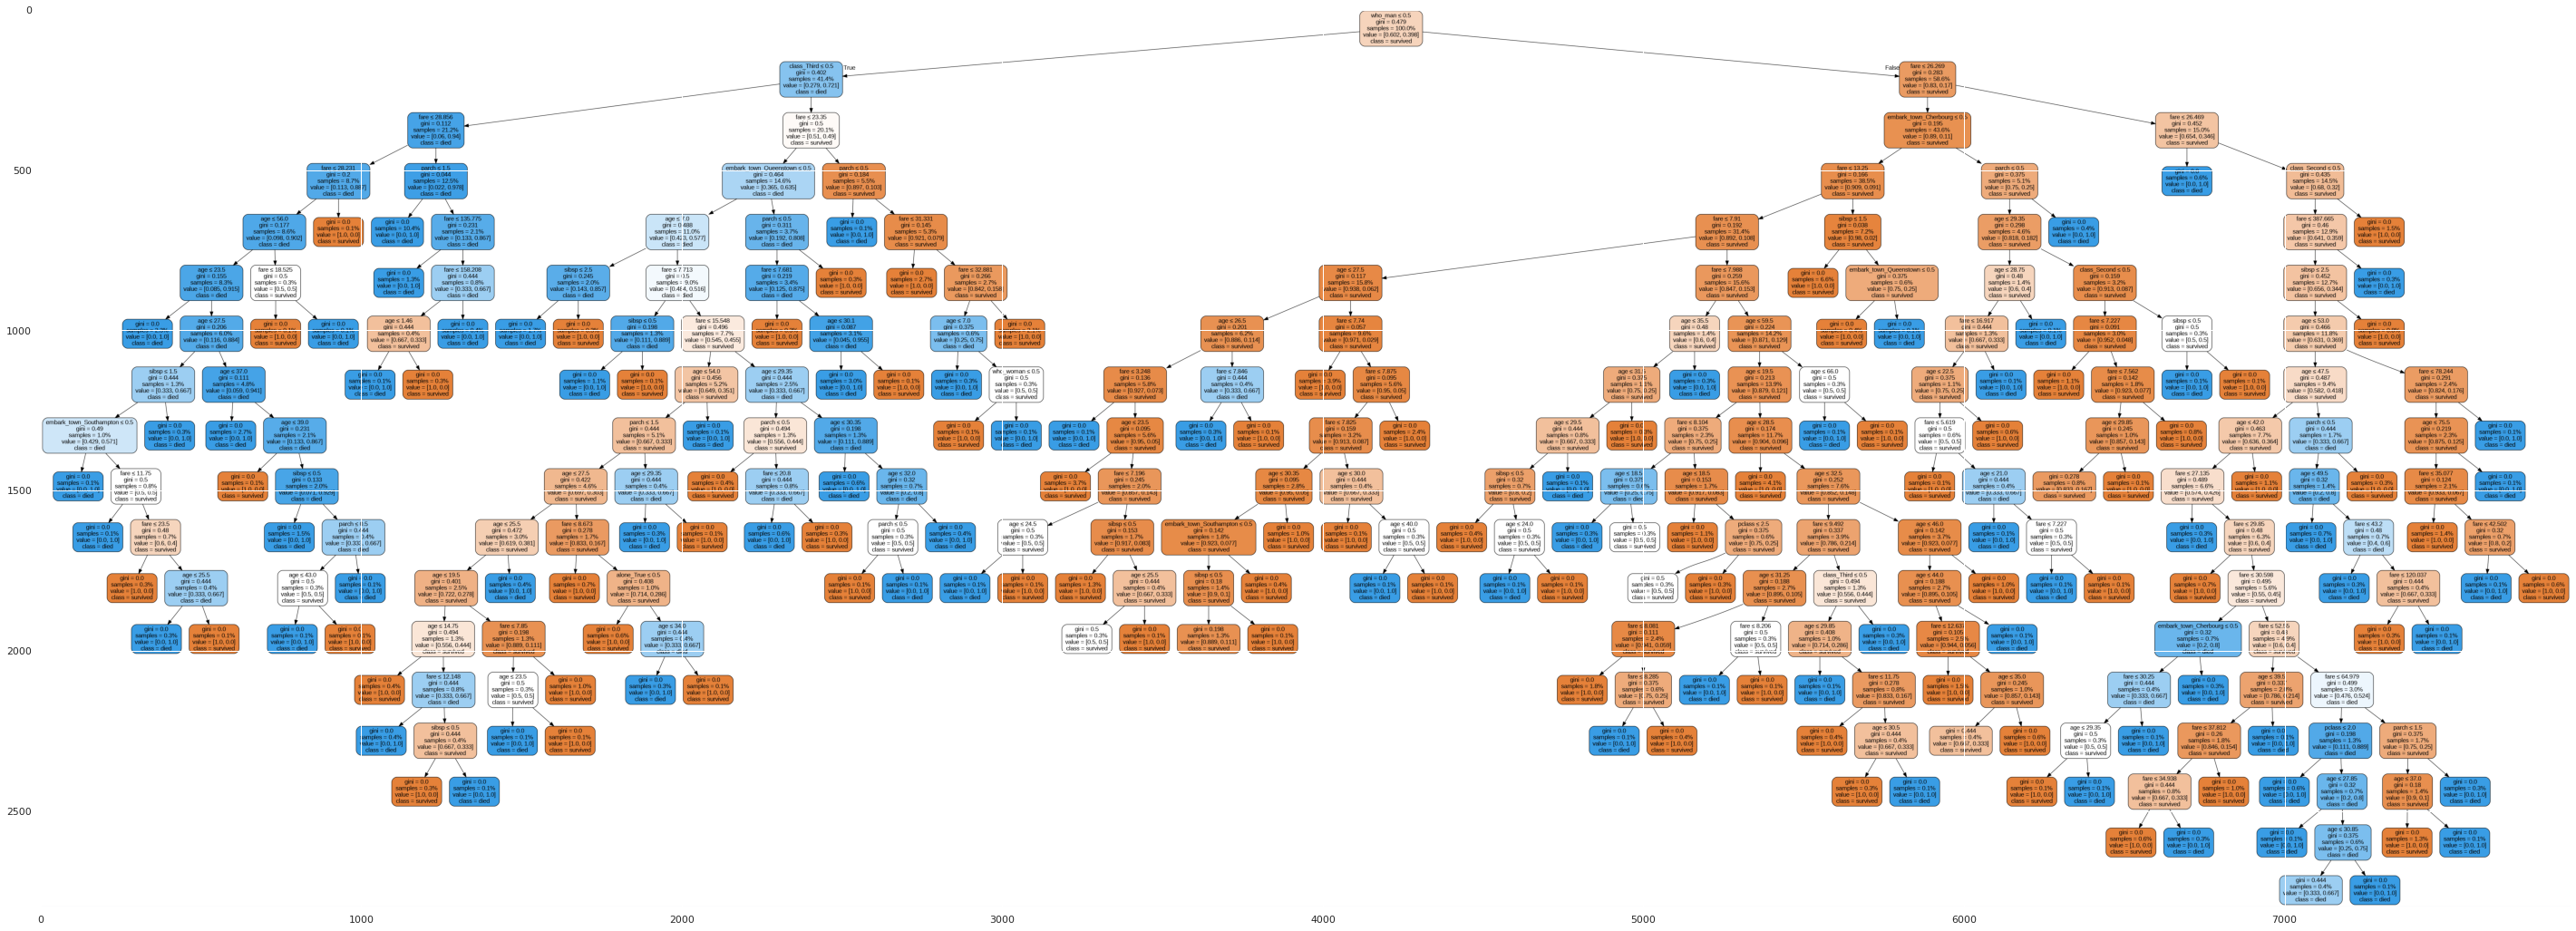

In [77]:
import graphviz
import matplotlib.pyplot as plt
import pydotplus
import matplotlib.image as mpimg
import io
from sklearn.tree import export_graphviz

def draw_tree(tree):
    dot_data = export_graphviz(tree,
                               out_file=None,
                               feature_names=features, 
                               class_names=["survived", "died"],
                               filled=True,
                               rounded=True,
                               special_characters=True,
                               proportion = True)
    
    graph = graphviz.Source(dot_data)
    graph.format = "png"
    graph.render("tree",view=True)
    plt.figure(figsize=(50,30))
    img = mpimg.imread("tree.png")
    imgplot = plt.imshow(img)

    plt.show()
    
draw_tree(tree)


Another good functionality of decision trees is that they give us an indication of how important is each variable. A fitted tree can show us the variable importance with the attribute `feature_importances_`. The feature importances are calculated based on the information gained by each variable (that is, which variables split the classes better).

In [78]:
tree.feature_importances_

array([0.00204394, 0.18582444, 0.03541376, 0.05210163, 0.27888687,
       0.00459528, 0.        , 0.00987835, 0.09484258, 0.        ,
       0.31553793, 0.00301565, 0.00564122, 0.01078675, 0.00143161])

In [79]:
dict(zip(
    features,
    tree.feature_importances_
))

{'pclass': 0.002043941129066464,
 'age': 0.18582443823899536,
 'sibsp': 0.035413764946110794,
 'parch': 0.05210162739108447,
 'fare': 0.278886868503622,
 'alone_True': 0.004595277479868396,
 'class_First': 0.0,
 'class_Second': 0.009878349334015582,
 'class_Third': 0.09484258461551368,
 'who_child': 0.0,
 'who_man': 0.3155379257051497,
 'who_woman': 0.0030156508461636347,
 'embark_town_Cherbourg': 0.005641215030404076,
 'embark_town_Queenstown': 0.010786751103585302,
 'embark_town_Southampton': 0.0014316056764205342}

For example, we see that on this tree the most important features in predicting if a passenger will survive are "fare", "age" and "gender".

## <font color='#31394d'> Max Depth </font>

In [80]:
DecisionTreeClassifier?

These are the most important hyperparameters for scikit-learn `DecisionTreeClassifier`:

Here is a great article that goes over how to understand and potentially use these for tuning your model ... 
https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680


* **criterion** : The partition criterion to use, we can use either `gini`, or `entropy` 

* **max_depth** (int>1) : The max depth the tree can achieve. We define as depth as the number of nodes an observation goes through (how many *questions* are asked).

* **max_features** (int or float(percentage)):  The maximum number of potential partitions evaluated when we split a node.

* **max_leaf_nodes** (int or None): Max number of leaves in the tree.

* **min_impurity_decrease** (float) : The minimum information gain required in a node to split it (if no feature provides that minimum, the node becomes a leaf).

* **class_weight** : For imbalanced classes, we can use `class_weight`, which is a dictionary with the shape `{class: weight}`, so sklearn takes the class weights into consideration. We can also use `class_weight=balanced` so sklearn creates the weights automatically based on class distribution.

Decision trees are prone to overfitting, there are some hyperparameters that help us control this:

* **min_samples_leaf** (int or float(percentage)) : Minimum number of observations on a node to consider the node a leaf. Default value is 1, this means that by default sklearn will create leaves with one observation (and this memorize the dataset).

* **min_samples_split** (int or float(percentage)) : Minimum number of observations on a node to generate a partition. By default is 2, this means sklearn will split all nodes with 2 or more observations by default.

For example, we can create a simpler tree by setting the maximum depth

In [81]:
simple_tree = DecisionTreeClassifier(max_depth=3)

In [82]:
simple_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

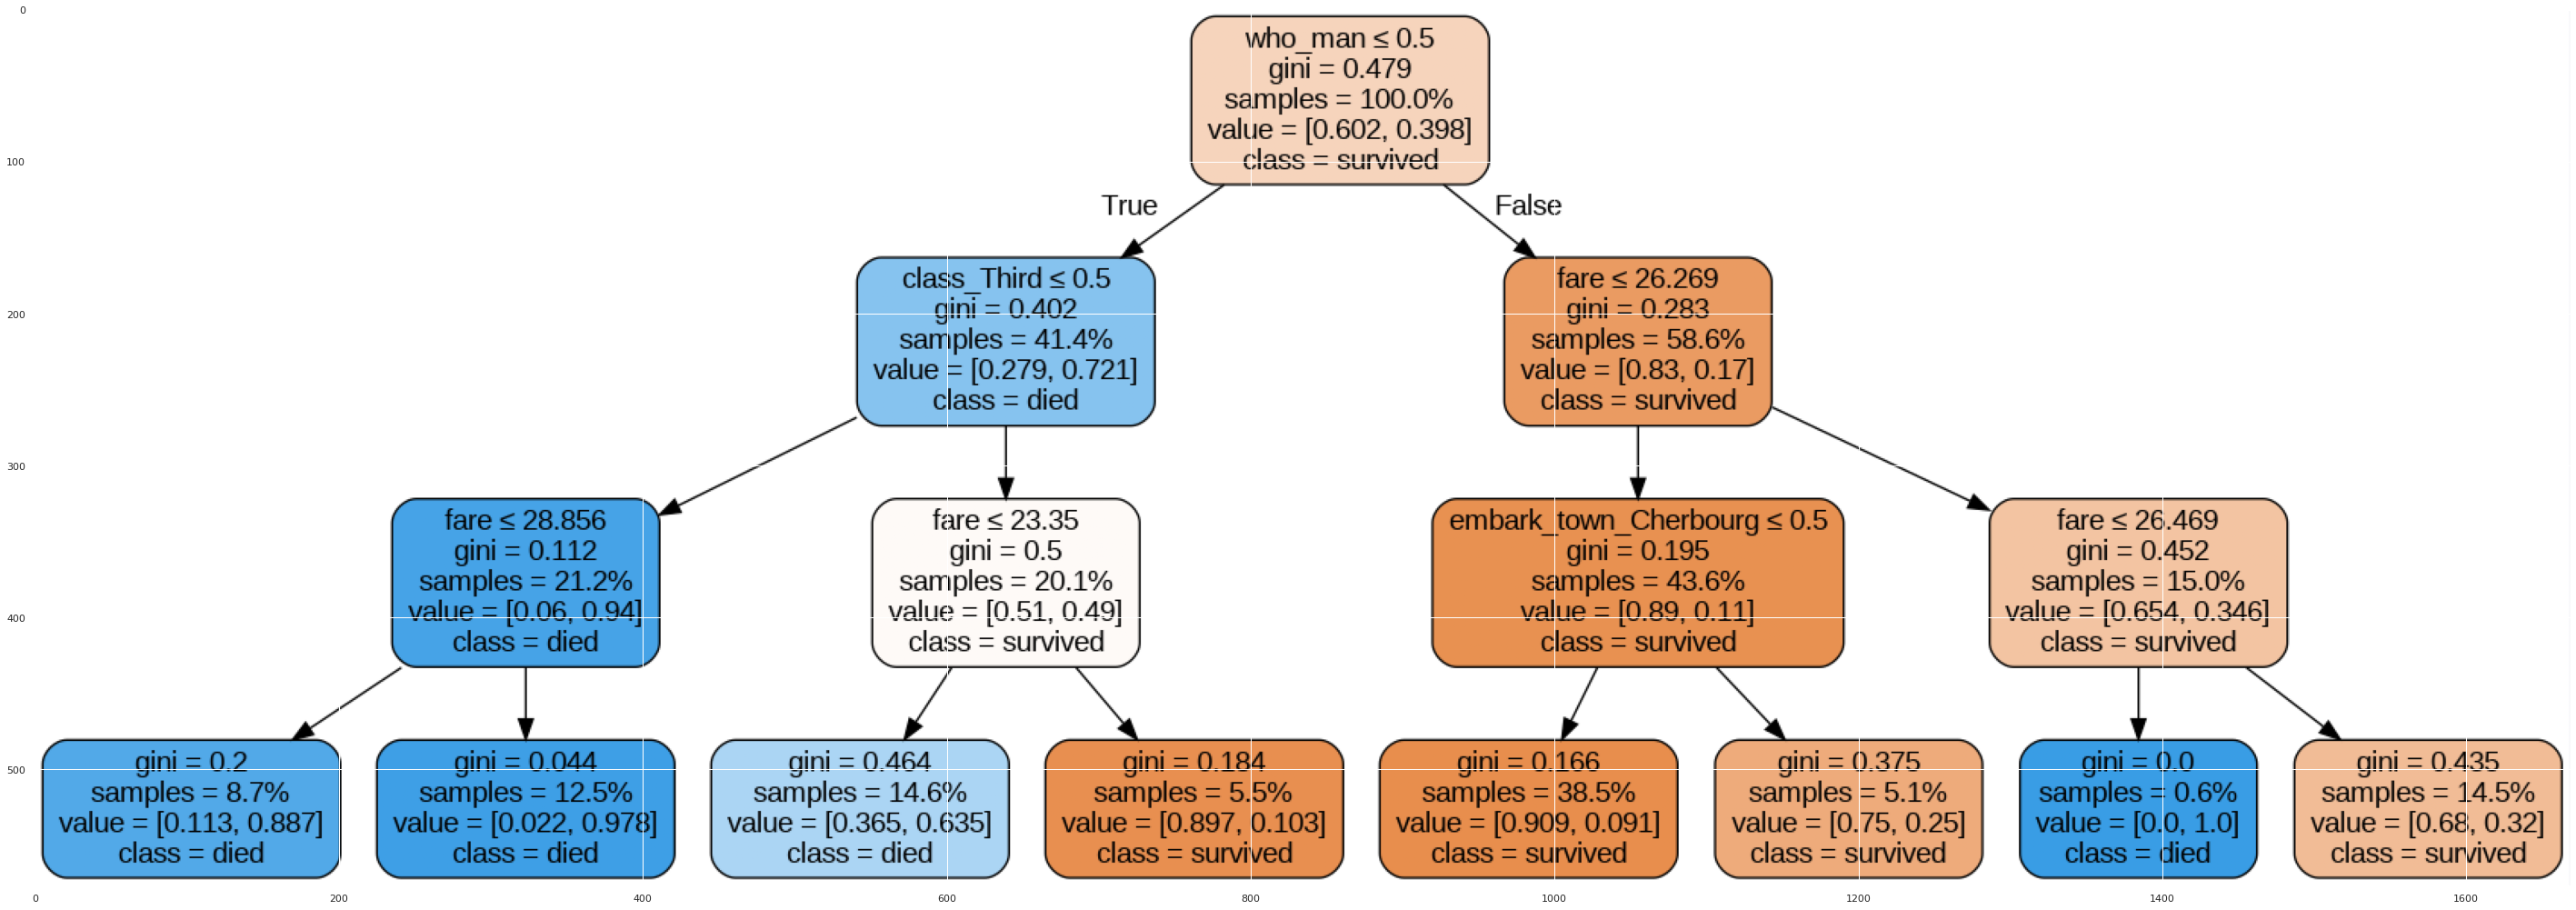

In [83]:
draw_tree(simple_tree)

In [84]:
simple_predictions = simple_tree.predict(X_test)
print(metrics.confusion_matrix(y_test, simple_predictions))

[[108  13]
 [ 17  40]]


In [85]:
print(metrics.accuracy_score(y_test, simple_predictions))
print(metrics.accuracy_score(y_test, predictions))

0.8314606741573034
0.7528089887640449


So we see this simple tree performs much better than the initial tree (that was overfitting), and it is also very simple to explain!

But how do we know what the optimal depth is? Well, this is a balance of practicality and "hyperparameter tuning". Let's test a number of depths.

In [86]:
# let's test a range of depths from 2:10 using a for loop

depths = np.arange(2,10) # define the depths
results = [] # create an empty data frame for our results

for depth in depths:
    best_depth_tree = DecisionTreeClassifier(max_depth = depth) # creating an instance of a decision tree
    results.append(cross_val_score(best_depth_tree, X, y, scoring="accuracy", # getting the cv accuracy metric for the tree at each depth
                cv=3).mean())


In [87]:
test = pd.DataFrame({"depths":depths, "mean_acc":results})
test.sort_values("mean_acc", ascending=False)

,depths,mean_acc
1,3,0.821170
2,4,0.816654
0,2,0.799807
4,6,0.795284
3,5,0.782946
5,7,0.778407
7,9,0.772803
6,8,0.772796
